In [281]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')
plt.rcParams.update({'font.size':16,'font.family':'serif'})

filter out the negative funds and 0 funds

In [5]:
# loan_df = pd.read_csv('loans.csv')
loan_df = pd.read_csv('data/loans.csv')
loan_df = loan_df[loan_df['amount_funded_by_investors'] > 0]
loan_df['fico_ordinal'] = loan_df['fico_range'].apply(lambda x: x.split('-')[0])
loan_df['fico_ordinal']=loan_df['fico_ordinal'].astype(int)
def classify_credit(score):
    if score <= 669:
        return "Fair"
    elif score <=739:
        return "Good"
    elif score <= 799:
        return "Very Good"
    elif score <= 850:
        return "Exceptional"
loan_df['fico_group'] = loan_df['fico_ordinal'].apply(lambda x: classify_credit(x))
pd.get_dummies(loan_df['fico_group'])
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df['fico_group'])], axis=1)
## Log of the loan amount funded
loan_df['amount_funded_by_investors_log'] = np.log(loan_df['amount_funded_by_investors'])

In [6]:
loan_df.head(10)

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_ordinal,fico_group,Exceptional,Fair,Good,Very Good,amount_funded_by_investors_log
0,8.90,735-739,20000.0,20000.0,36.0,735,Good,0,0,1,0,9.903488
1,12.12,715-719,19200.0,19200.0,36.0,715,Good,0,0,1,0,9.862666
2,21.98,690-694,35000.0,35000.0,60.0,690,Good,0,0,1,0,10.463103
3,9.99,695-699,10000.0,9975.0,36.0,695,Good,0,0,1,0,9.207837
4,11.71,695-699,12000.0,12000.0,36.0,695,Good,0,0,1,0,9.392662
5,15.31,670-674,6000.0,6000.0,36.0,670,Good,0,0,1,0,8.699515
6,7.90,720-724,10000.0,10000.0,36.0,720,Good,0,0,1,0,9.210340
7,17.14,705-709,33500.0,33450.0,60.0,705,Good,0,0,1,0,10.417807
8,14.33,685-689,14675.0,14675.0,36.0,685,Good,0,0,1,0,9.593901
9,6.91,715-719,7000.0,7000.0,36.0,715,Good,0,0,1,0,8.853665


# 3 Year Loan Analysis

In [7]:
loan_3yr_df = loan_df[loan_df['loan_length'] < 37]

In [8]:
loan_3yr_df.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_ordinal,fico_group,Exceptional,Fair,Good,Very Good,amount_funded_by_investors_log
0,8.90,735-739,20000.0,20000.0,36.0,735,Good,0,0,1,0,9.903488
1,12.12,715-719,19200.0,19200.0,36.0,715,Good,0,0,1,0,9.862666
3,9.99,695-699,10000.0,9975.0,36.0,695,Good,0,0,1,0,9.207837
4,11.71,695-699,12000.0,12000.0,36.0,695,Good,0,0,1,0,9.392662
5,15.31,670-674,6000.0,6000.0,36.0,670,Good,0,0,1,0,8.699515


In [24]:
X = loan_3yr_df[['amount_funded_by_investors','fico_ordinal']]
#X = loan_3yr_df[['amount_funded_by_investors_log']]

y= loan_3yr_df['interest_rate']
model_3yr = sm.OLS(y,sm.add_constant(X)).fit()

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
print(model_3yr.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     1927.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:13:50   Log-Likelihood:                -4231.5
No. Observations:                1944   AIC:                             8469.
Df Residuals:                    1941   BIC:                             8486.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [26]:
for i,col in enumerate(X):
    print(f'{col}: {variance_inflation_factor(X.values , i)}')

amount_funded_by_investors: 3.390902038092141
fico_ordinal: 3.3909020380921424


### QQ Plot

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


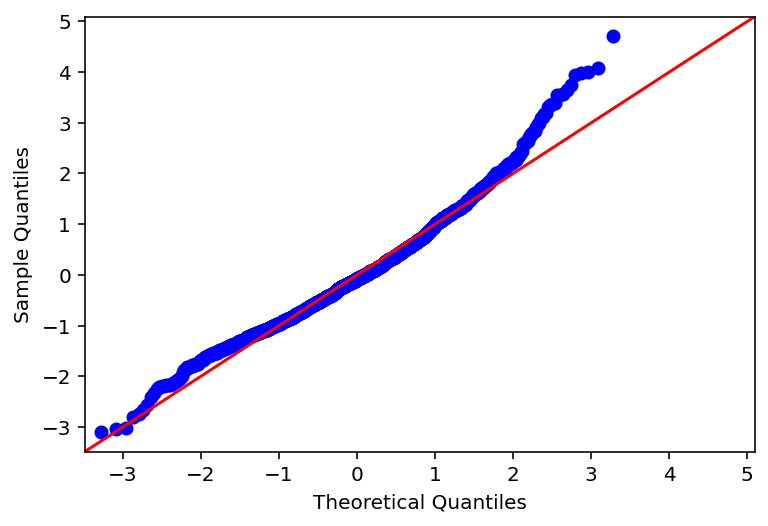

In [27]:
result = model_3yr.resid
fig = sm.qqplot(result, fit=True, line="45")
plt.show()

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


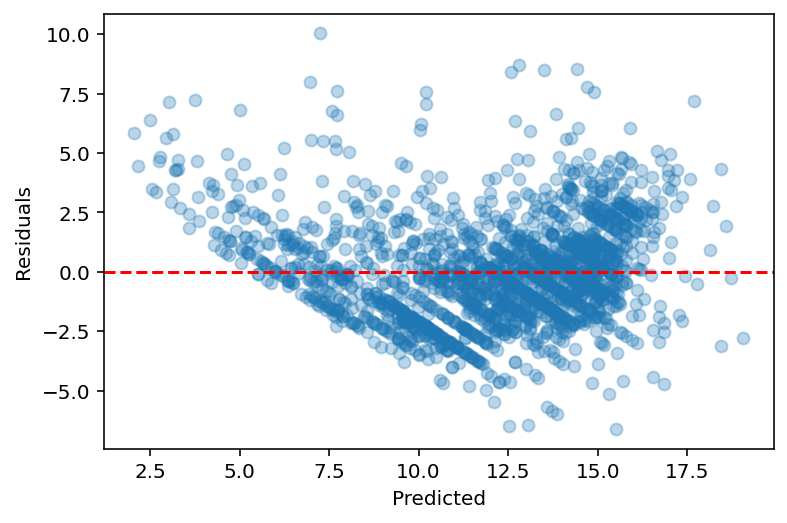

In [28]:
fig, ax = plt.subplots() 
predictions = model_3yr.predict(sm.add_constant(X)) 
ax.scatter(predictions, result, alpha=0.3) 
ax.axhline(0, color='r', ls='--') 
ax.set_xlabel('Predicted') 
ax.set_ylabel('Residuals'); 

In [29]:
X

,amount_funded_by_investors,fico_ordinal
0,20000.00,735
1,19200.00,715
3,9975.00,695
4,12000.00,695
5,6000.00,670
...,...,...
2490,6350.00,710
2492,23975.00,685
2495,10000.00,680
2496,6000.00,675


In [30]:
y

0        8.90
1       12.12
3        9.99
4       11.71
5       15.31
        ...  
2490    10.08
2492    14.65
2495    13.99
2496    12.42
2497    13.79
Name: interest_rate, Length: 1944, dtype: float64

ValueError: x and y must be the same size

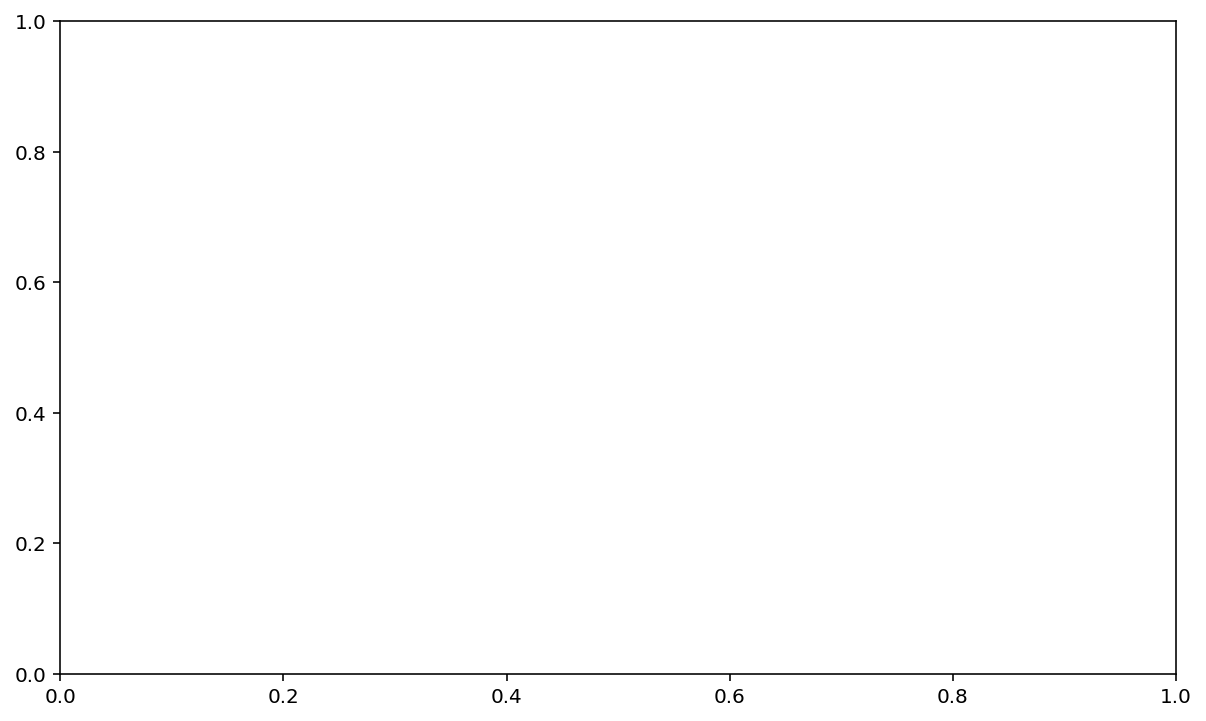

In [34]:

fig = plt.figure(figsize=(10,6)) 
ax = fig.add_subplot(111) 
ax.scatter(X, y, label='response (y)') 
ax.plot(X, predictions, c='r',label='prediction') 
ax.set_xlabel('x') 
ax.set_ylabel('y') 
ax.legend(); 

## 5 Year Loan Analysis

In [16]:
loan_5yr_df = loan_df[loan_df['loan_length'] > 37]

In [17]:
X = loan_5yr_df[['amount_funded_by_investors','fico_ordinal']]
y= loan_5yr_df['interest_rate']
model_5yr = sm.OLS(y,sm.add_constant(X)).fit()

In [18]:
print(model_5yr.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     937.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          3.94e-177
Time:                        05:11:05   Log-Likelihood:                -1145.5
No. Observations:                 548   AIC:                             2297.
Df Residuals:                     545   BIC:                             2310.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Normalize Data

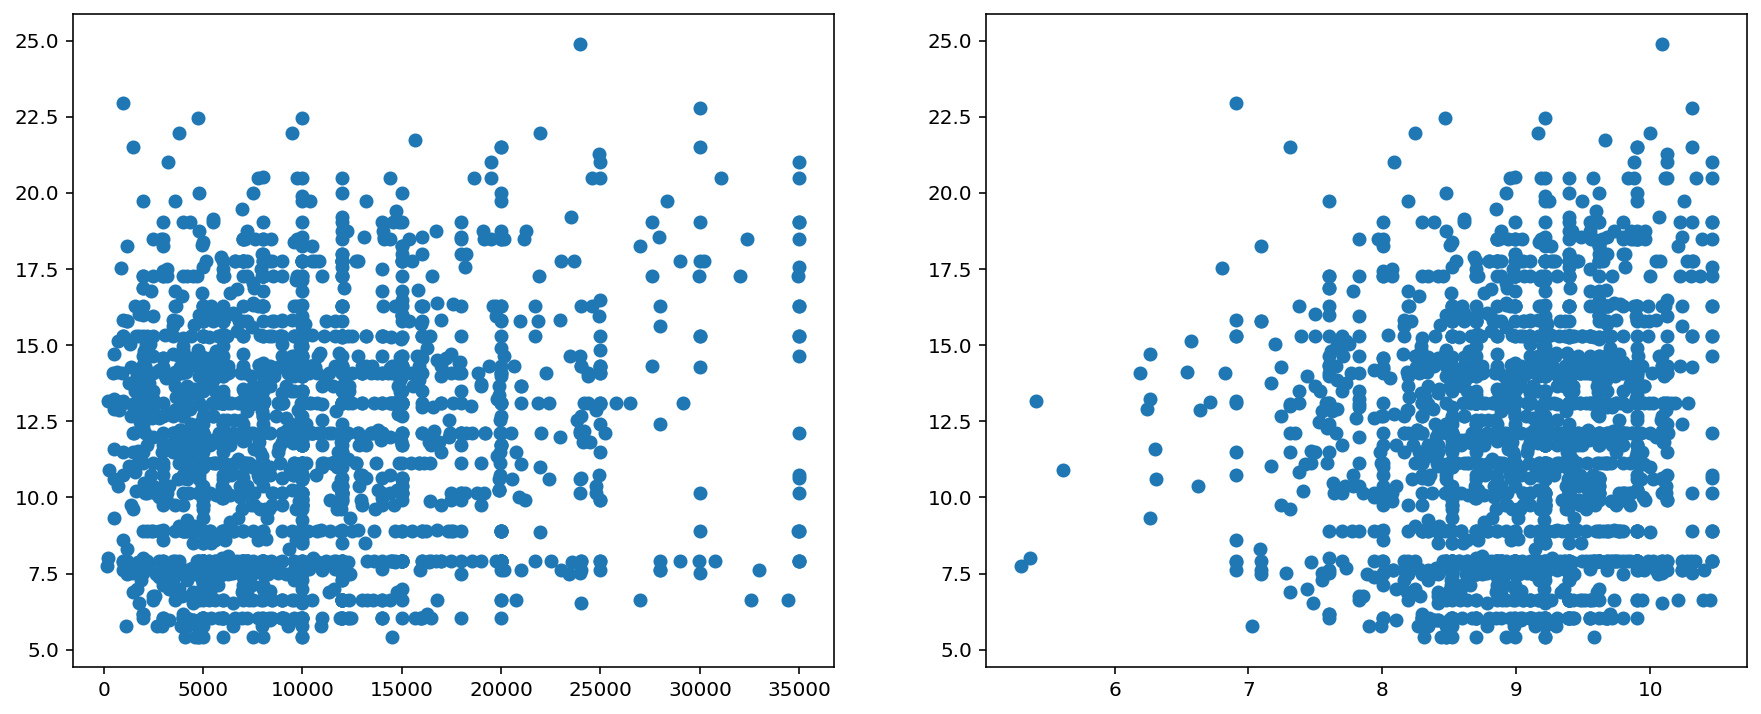

In [39]:
fig,axs = plt.subplots(1,2,figsize=(15,6))
axs[0].scatter(X['amount_funded_by_investors'],y)
axs[1].scatter(np.log(X['amount_funded_by_investors']),y)

In [49]:
normalized_X = (X-X.mean())/X.std()
normalized_y = (y-y.mean())/y.std()

In [50]:
model_5yr_normalized = sm.OLS(normalized_y,sm.add_constant(normalized_X)).fit()

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
print(model_5yr_normalized.summary())
print(model_5yr.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     1927.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:28:28   Log-Likelihood:                -1694.9
No. Observations:                1944   AIC:                             3396.
Df Residuals:                    1941   BIC:                             3413.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [53]:
for i,col in enumerate(normalized_X):
    print(f'{col}: {variance_inflation_factor(normalized_X.values , i)}')
for i,col in enumerate(X):
    print(f'{col}: {variance_inflation_factor(X.values , i)}')


amount_funded_by_investors: 1.0147261201513698
fico_ordinal: 1.0147261201513693
amount_funded_by_investors: 3.390902038092141
fico_ordinal: 3.3909020380921424


In [55]:
pd.get_dummies(loan_df['loan_length'])
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df['loan_length'])], axis=1)

loan_df.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_ordinal,fico_group,Exceptional,Fair,Good,Very Good,amount_funded_by_investors_log,36.0,60.0
0,8.90,735-739,20000.0,20000.0,36.0,735,Good,0,0,1,0,9.903488,1,0
1,12.12,715-719,19200.0,19200.0,36.0,715,Good,0,0,1,0,9.862666,1,0
2,21.98,690-694,35000.0,35000.0,60.0,690,Good,0,0,1,0,10.463103,0,1
3,9.99,695-699,10000.0,9975.0,36.0,695,Good,0,0,1,0,9.207837,1,0
4,11.71,695-699,12000.0,12000.0,36.0,695,Good,0,0,1,0,9.392662,1,0


In [56]:

def normalize_df_col(df,col):
    df[col+'_norm'] = (df[col]-df[col].mean())/df[col].std()
normalize_df_col(loan_df,'amount_funded_by_investors')
normalize_df_col(loan_df,'fico_ordinal')
loan_df.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_ordinal,fico_group,Exceptional,Fair,Good,Very Good,amount_funded_by_investors_log,36.0,60.0,amount_funded_by_investors_norm,fico_ordinal_norm
0,8.90,735-739,20000.0,20000.0,36.0,735,Good,0,0,1,0,9.903488,1,0,1.029959,0.833284
1,12.12,715-719,19200.0,19200.0,36.0,715,Good,0,0,1,0,9.862666,1,0,0.926469,0.260997
2,21.98,690-694,35000.0,35000.0,60.0,690,Good,0,0,1,0,10.463103,0,1,2.970396,-0.454362
3,9.99,695-699,10000.0,9975.0,36.0,695,Good,0,0,1,0,9.207837,1,0,-0.266900,-0.311290
4,11.71,695-699,12000.0,12000.0,36.0,695,Good,0,0,1,0,9.392662,1,0,-0.004941,-0.311290


In [59]:
X_columns = ['amount_funded_by_investors_norm','fico_ordinal_norm',60.0]
X = loan_df[X_columns]
y = loan_df['interest_rate']
model_norm = sm.OLS(y,sm.add_constant(X)).fit()
print(model_norm.summary())
print()
for i,col in enumerate(X):
    print(f'{col}: {variance_inflation_factor(X.values , i)}')

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     2433.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        05:48:24   Log-Likelihood:                -5393.7
No. Observations:                2492   AIC:                         1.080e+04
Df Residuals:                    2488   BIC:                         1.082e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


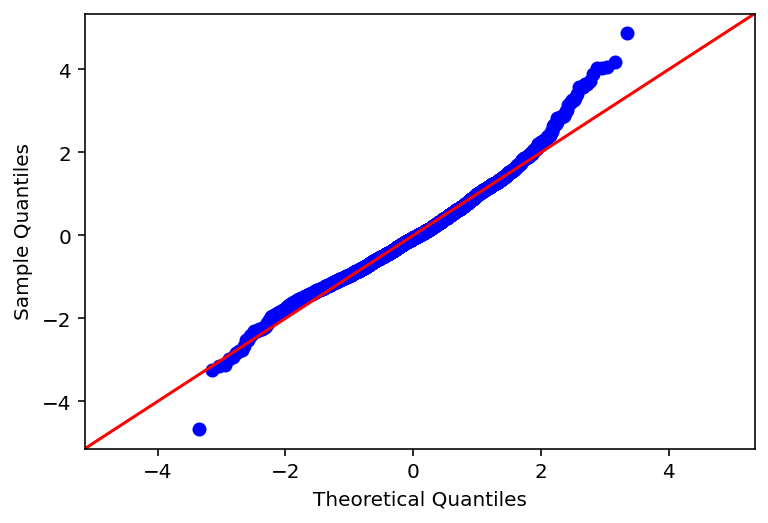

In [62]:
residuals = model_norm.resid
fig = sm.qqplot(residuals, fit=True, line="45")
plt.show()

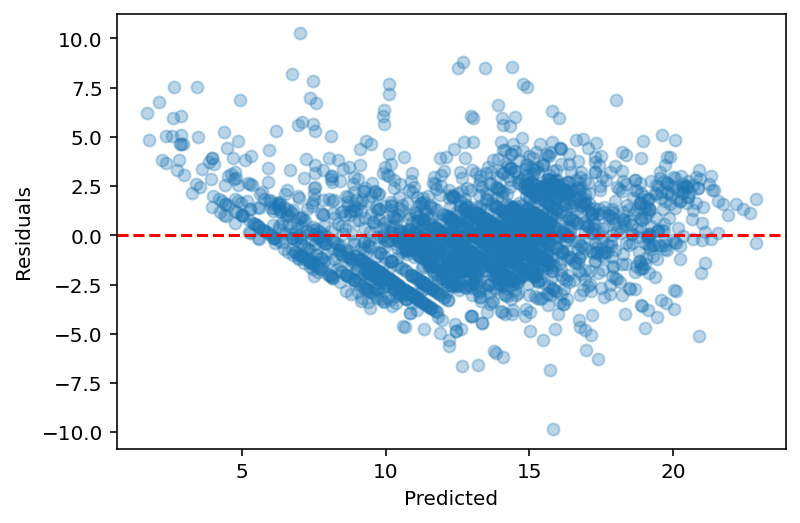

In [64]:
fig, ax = plt.subplots() 
predictions = model_norm.predict(sm.add_constant(X)) 
ax.scatter(predictions, residuals, alpha=0.3) 
ax.axhline(0, color='r', ls='--') 
ax.set_xlabel('Predicted') 
ax.set_ylabel('Residuals'); 

In [100]:
def fit_model(X,y):
    model = sm.OLS(y,sm.add_constant(X)).fit()
    print(model.summary())
    if X.shape[1]>1:
        print('\nVIF scores:')
        for i,col in enumerate(X):
            print(f'{col}: {variance_inflation_factor(X.values , i)}')
    return model
        
def plot_qqplot(model):
    residuals = model.resid
    fig = sm.qqplot(residuals, fit=True, line="45")
    plt.show()


def plot_residuals(model):
    fig, ax = plt.subplots() 
    predictions = model.predict(sm.add_constant(X))
    residuals = model.resid
    ax.scatter(predictions, residuals, alpha=0.3) 
    ax.axhline(0, color='r', ls='--') 
    ax.set_xlabel('Predicted') 
    ax.set_ylabel('Residuals'); 



/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2780.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        06:08:53   Log-Likelihood:                -5637.8
No. Observations:                2492   AIC:                         1.128e+04
Df Residuals:                    2489   BIC:                         1.130e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.1159      0.05

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


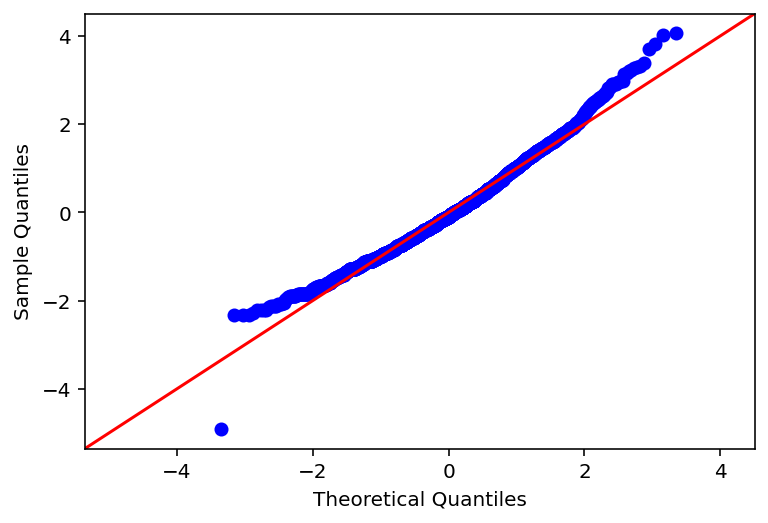

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


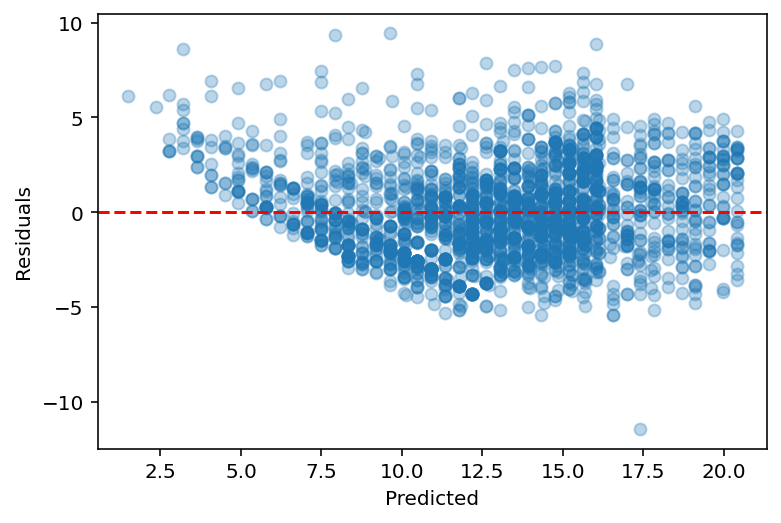

In [75]:
X_columns = ['fico_ordinal_norm',60.0]
X = loan_df[X_columns]
y = loan_df['interest_rate']
model = fit_model(X,y)
plot_qqplot(model)
plot_residuals(model)

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     2372.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        06:10:47   Log-Likelihood:                -5771.0
No. Observations:                2492   AIC:                         1.155e+04
Df Residuals:                    2489   BIC:                         1.157e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


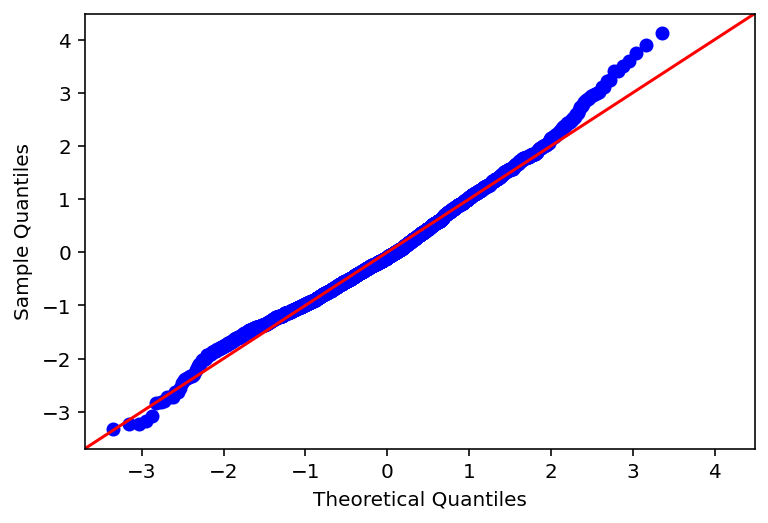

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


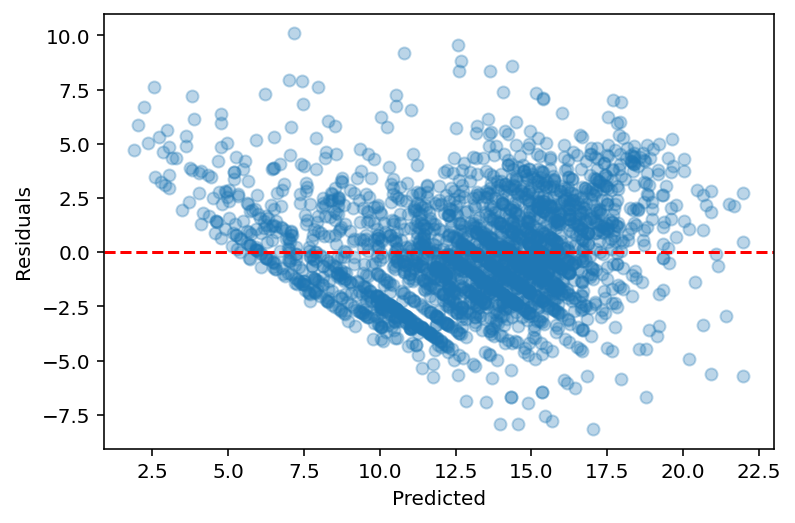

In [77]:
X_columns = ['amount_funded_by_investors_norm','fico_ordinal_norm']
X = loan_df[X_columns]
y = loan_df['interest_rate']
model = fit_model(X,y)
plot_qqplot(model)
plot_residuals(model)

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     2530.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        08:07:34   Log-Likelihood:                -6226.5
No. Observations:                2492   AIC:                         1.246e+04
Df Residuals:                    2490   BIC:                         1.247e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0751      0.05

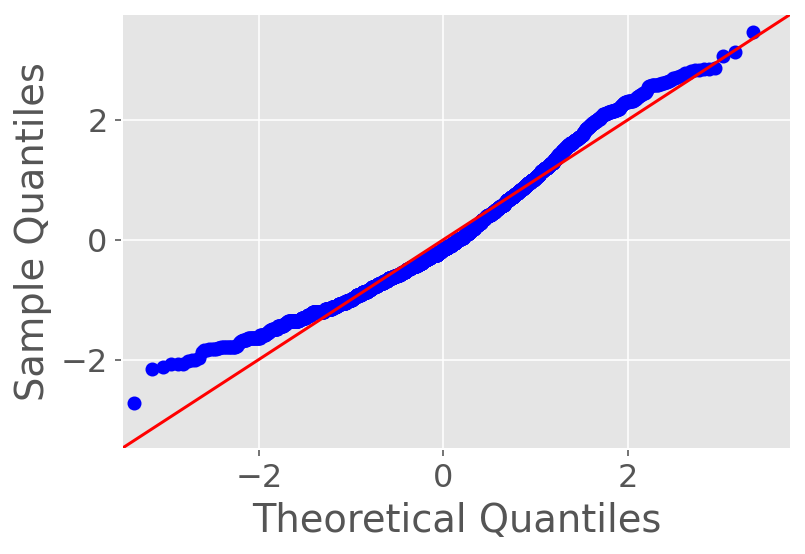

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


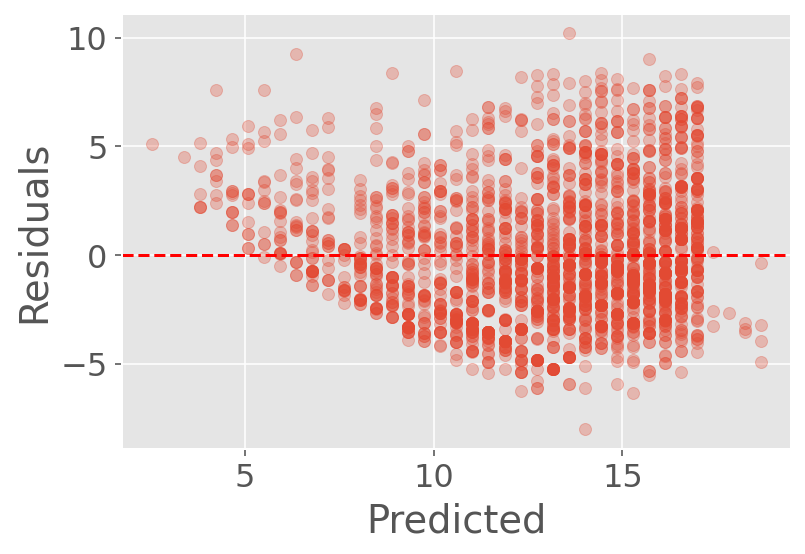

In [135]:
X_columns = ['fico_ordinal_norm']
X = loan_df[X_columns]
y = loan_df['interest_rate']
model = fit_model(X,y)
plot_qqplot(model)
plot_residuals(model)

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


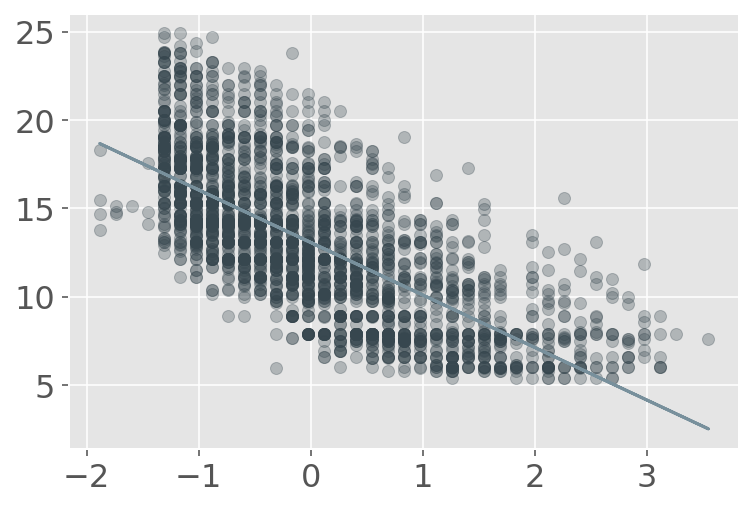

In [147]:
fig,ax = plt.subplots()
y_hat = model.predict(sm.add_constant(X))
ax.scatter(X,y,alpha=0.3,color='#37474f')
ax.plot(X,y_hat,color='#78909c')


/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     2530.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        08:40:03   Log-Likelihood:                -6226.5
No. Observations:                2492   AIC:                         1.246e+04
Df Residuals:                    2490   BIC:                         1.247e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           73.0182      1.193     61.194   

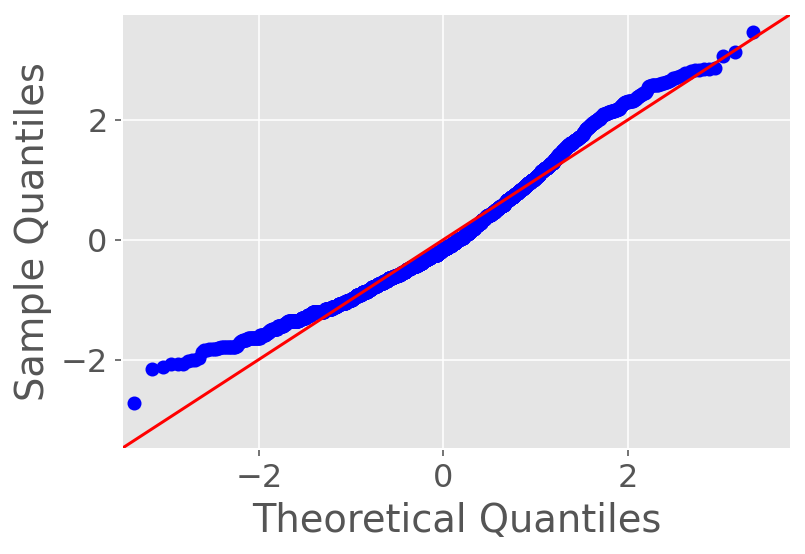

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


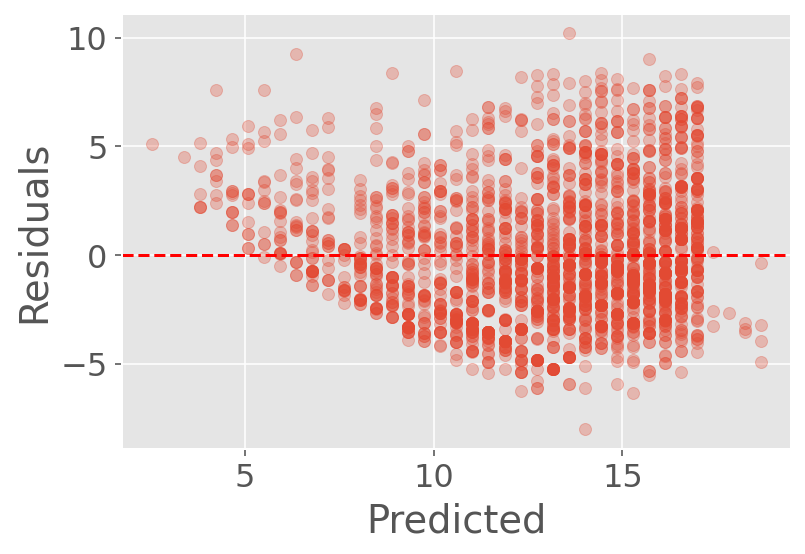

In [148]:
X_columns = ['fico_ordinal']
X = loan_df[X_columns]
y = loan_df['interest_rate']
model = fit_model(X,y)
plot_qqplot(model)
plot_residuals(model)


In [261]:
plt.rcParams['axes.titlesize']

'x-large'

In [282]:
fontname=None

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


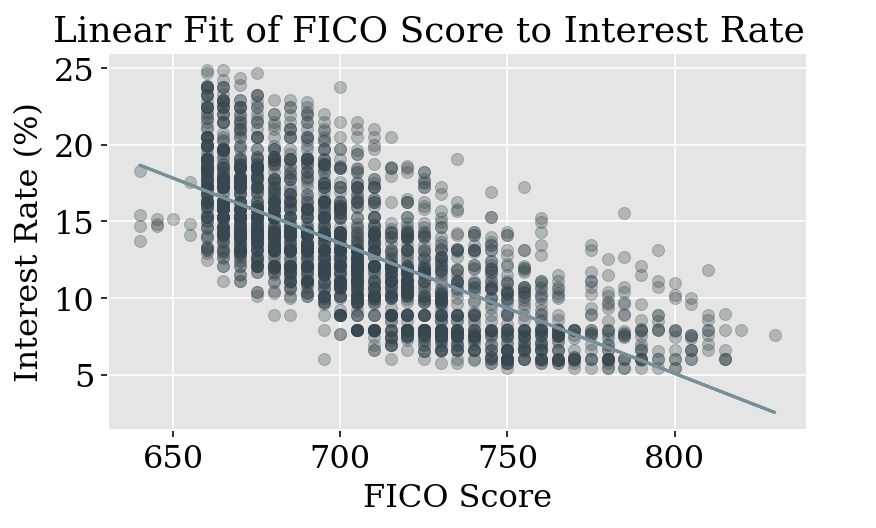

In [284]:
hfontdict = {'fontsize': 18}
fontdict = {'fontsize': 16}
fig,ax = plt.subplots()
y_hat = model.predict(sm.add_constant(X))
ax.scatter(X,y,alpha=0.3,color='#37474f')
ax.plot(X,y_hat,color='#78909c')
ax.set_xlabel('FICO Score',fontdict=fontdict,fontname=fontname)
ax.set_ylabel('Interest Rate (%)',fontdict=fontdict,fontname=fontname)
ax.set_title('Linear Fit of FICO Score to Interest Rate     ',fontdict=hfontdict,fontname=fontname)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
fig.tight_layout()
fig.savefig('images/fico_vs_rate_fit.png',dpi=300)

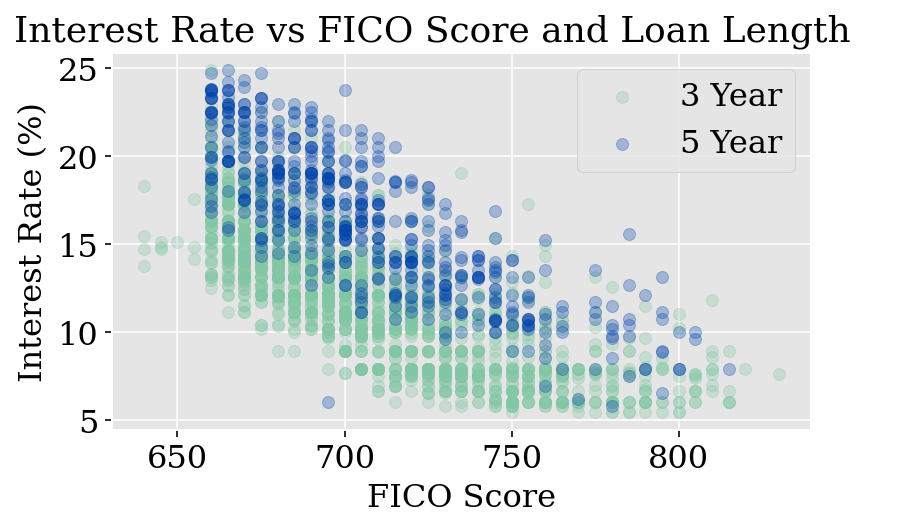

In [298]:
colors=['#82c7a5','#0145ac']
hfontdict = {'fontsize': 18}
fontdict = {'fontsize': 16}
fig,ax = plt.subplots()
y_hat = model.predict(sm.add_constant(X))
ax.scatter(loan_3yr_df.fico_ordinal,loan_3yr_df.interest_rate,alpha=.3,label='3 Year',color=colors[0])
ax.scatter(loan_5yr_df.fico_ordinal,loan_5yr_df.interest_rate,alpha=.3,label='5 Year',color=colors[1])
# ax.scatter(X,y,alpha=0.3,color='#37474f')
# ax.plot(X,y_hat,color='#78909c',label='Combined Fit')
ax.set_xlabel('FICO Score',fontdict=fontdict,fontname=fontname)
ax.set_ylabel('Interest Rate (%)',fontdict=fontdict,fontname=fontname)
ax.set_title('Interest Rate vs FICO Score and Loan Length     ',fontdict=hfontdict,fontname=fontname)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
ax.legend()
fig.tight_layout()
fig.savefig('images/fico_vs_rate_length_split.png',dpi=300)

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     476.1
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.99e-244
Time:                        06:51:18   Log-Likelihood:                -6534.9
No. Observations:                2492   AIC:                         1.308e+04
Df Residuals:                    2488   BIC:                         1.310e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.4766      0.080    169.478      

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


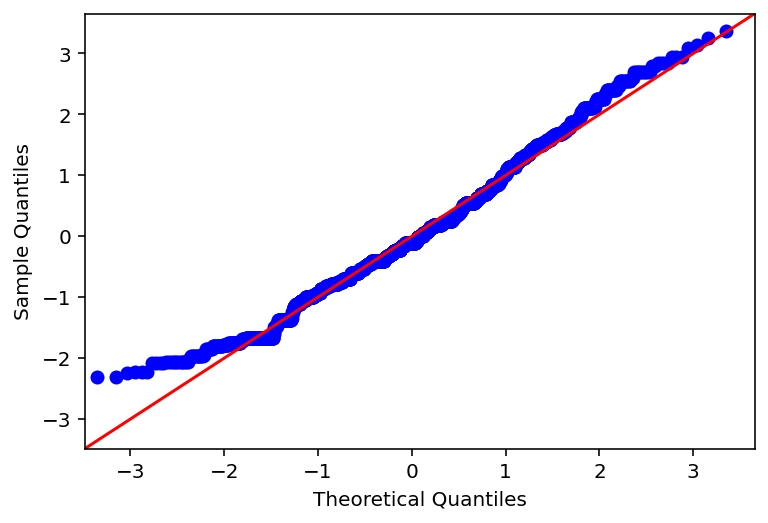

/home/richy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


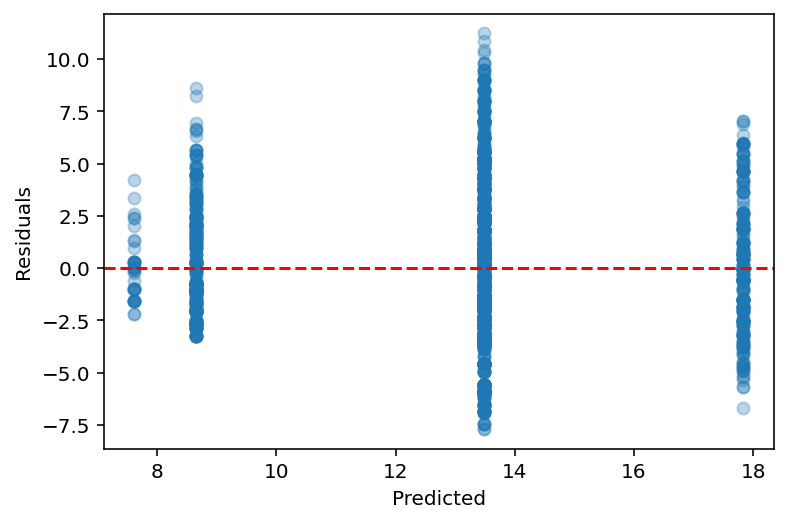

In [104]:
X_columns = ['Exceptional','Very Good','Fair']
X = loan_df[X_columns]
y = loan_df['interest_rate']
model = fit_model(X,y)
plot_qqplot(model)
plot_residuals(model)

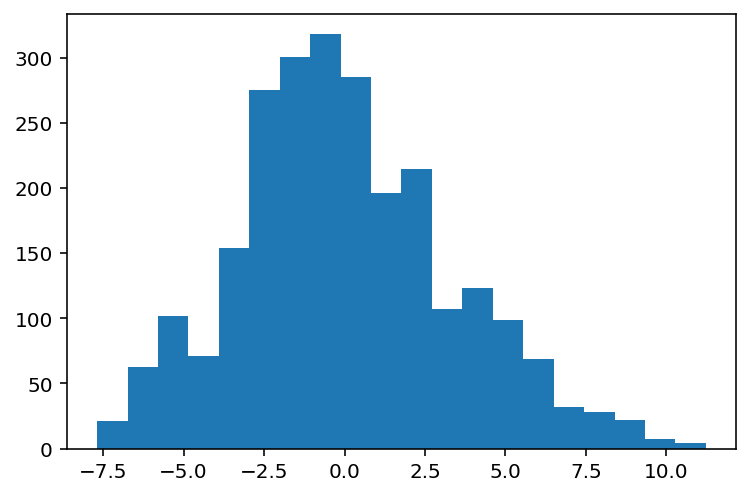

In [106]:
plt.hist(model.resid,bins=20);

## Check Assumptions

### Linearity

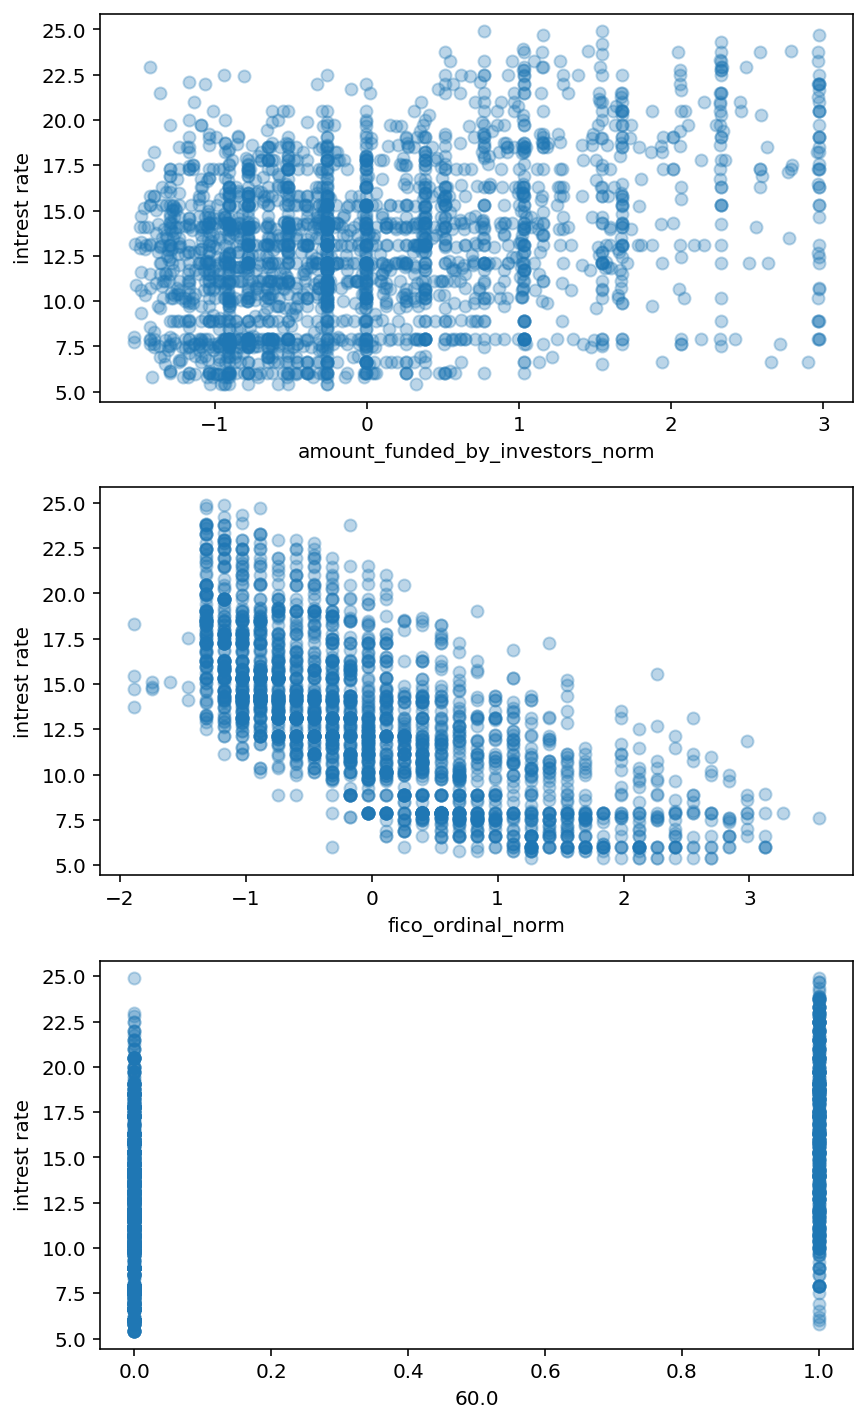

In [86]:
X_columns = ['amount_funded_by_investors_norm','fico_ordinal_norm',60.0]
X = loan_df[X_columns]

fig,axs = plt.subplots(X.shape[1],1,figsize=(6,10))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(X.iloc[:,i],y,alpha=0.3)
    ax.set_xlabel(X_columns[i])
    ax.set_ylabel('intrest rate')
fig.tight_layout()

In [94]:
for i,(name,col) in enumerate(zip(X_columns,X)):
    corr, _ = pearsonr(X.iloc[:,i], y)
    print(f'{name}: {corr}')

amount_funded_by_investors_norm: 0.336273756103675
fico_ordinal_norm: -0.7099117848791165
60.0: 0.42331759595711876


In [97]:
X_columns = ['amount_funded_by_investors_log','amount_funded_by_investors','amount_funded_by_investors_norm']
X = loan_df[X_columns]
for i,(name,col) in enumerate(zip(X_columns,X)):
    corr, _ = pearsonr(X.iloc[:,i], y)
    print(f'{name}: {corr}')

amount_funded_by_investors_log: 0.2752478334257762
amount_funded_by_investors: 0.33627375610367494
amount_funded_by_investors_norm: 0.336273756103675


In [95]:
loan_df.columns

Index([                  'interest_rate',                      'fico_range',
                      'amount_requested',      'amount_funded_by_investors',
                           'loan_length',                    'fico_ordinal',
                            'fico_group',                     'Exceptional',
                                  'Fair',                            'Good',
                             'Very Good',  'amount_funded_by_investors_log',
                                    36.0,                              60.0,
       'amount_funded_by_investors_norm',               'fico_ordinal_norm'],
      dtype='object')

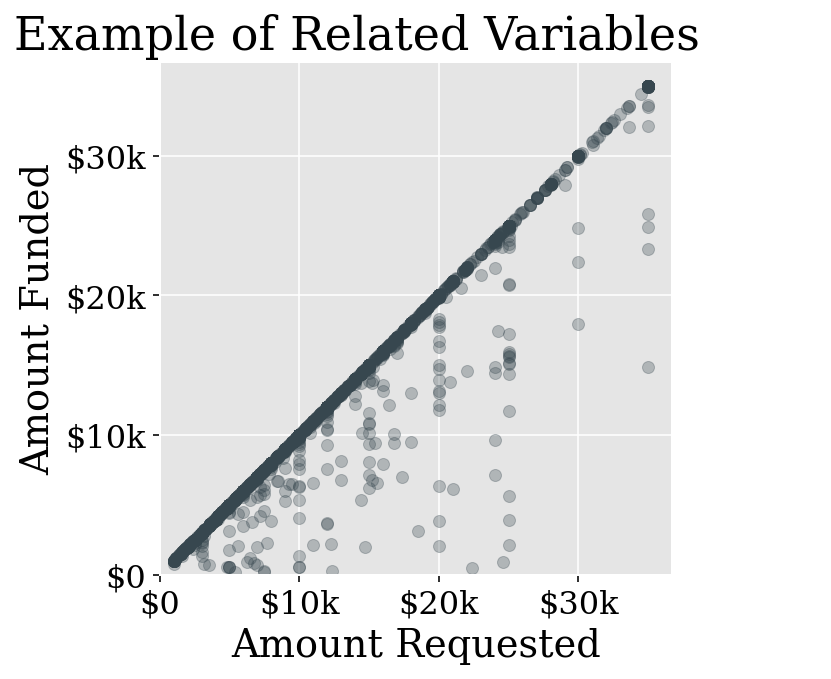

In [285]:
plt.rcParams.update({'font.size':16})
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(loan_df.amount_requested,loan_df.amount_funded_by_investors,alpha=0.3,color='#37474f')
ax.set_xlabel('Amount Requested',fontname=fontname)
ax.set_ylabel('Amount Funded',fontname=fontname)
ax.set_title('Example of Related Variables        ',fontname=fontname)
ax.axis('scaled')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
ax.set_xticks([0,10000,20000,30000])
# ax.set_xticklabels(['$0','$10,000','$20,000','$30,000'])
ax.set_xticklabels(['$0','$10k','$20k','$30k'])
ax.set_yticks([0,10000,20000,30000])
# ax.set_yticklabels(['$0','$10,000','$20,000','$30,000'])
ax.set_yticklabels(['$0','$10k','$20k','$30k'])
fig.tight_layout()
fig.savefig('images/amount_req_fund_relation.png',dpi=300)

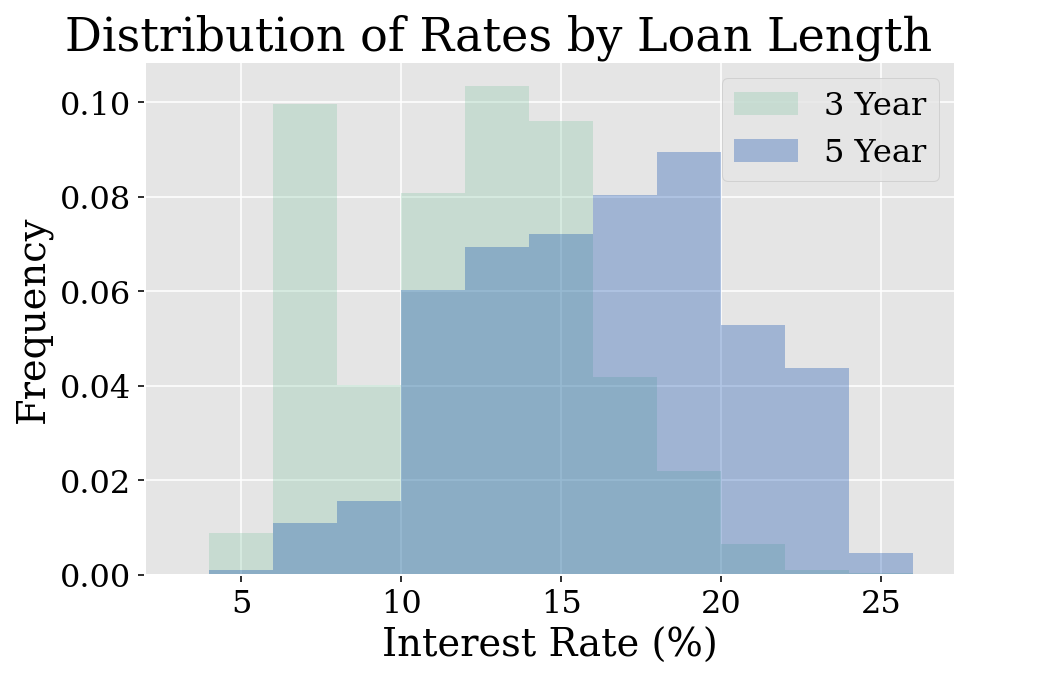

In [286]:
fig,ax = plt.subplots(figsize=(7,5))
bins=range(0,28,2)
counts,bins,_ = ax.hist(loan_df[loan_df['loan_length']==36].interest_rate,label='3 Year',color='#82c7a5',bins=bins,alpha=.3,density=True)
counts,bins,_ = ax.hist(loan_df[loan_df['loan_length']==60].interest_rate,label='5 Year',color='#0145ac',bins=bins,alpha=.3,density=True)
ax.set_xlabel('Interest Rate (%)',fontname=fontname)
ax.set_ylabel('Frequency',fontname=fontname)
ax.set_title('Distribution of Rates by Loan Length       ',fontname=fontname)
ax.set_xlim(left=2)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')
ax.legend()
fig.tight_layout();
fig.savefig('images/hist_of_intrest_rates.png',dpi=300)


In [280]:
plt.rcParamsDefault

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [275]:
colors = ['#37474f','#78909c']
fontname = 'Norasi'

In [238]:
import matplotlib
matplotlib.get_cachedir()

'/home/richy/.cache/matplotlib'

In [239]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

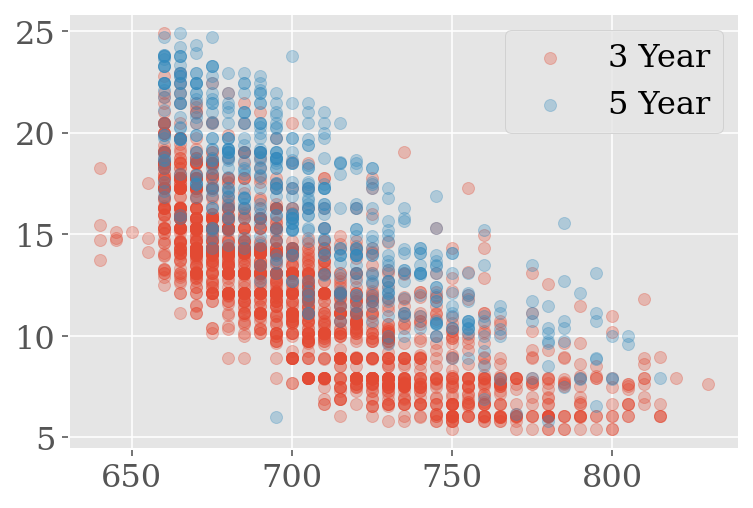

In [290]:

fig,ax = plt.subplots()
ax.scatter(loan_3yr_df.fico_ordinal,loan_3yr_df.interest_rate,alpha=.3,label='3 Year')
ax.scatter(loan_5yr_df.fico_ordinal,loan_5yr_df.interest_rate,alpha=.3,label='5 Year')
ax.legend()